<a href="https://www.kaggle.com/code/artamevia/modul-6-v3?scriptVersionId=155256425" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import time
import PIL.Image as Image
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.image as mpimg
%matplotlib inline
import datetime
from tqdm.keras import TqdmCallback
from skimage import transform
import urllib
import os
import re

import tensorflow as tf
import tensorflow_hub as hub
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
INPUT_DIR = "/kaggle/input/private-modul-6-dataset"
TRAIN_DIR = INPUT_DIR + "/train"
TEST_DIR = INPUT_DIR + "/test"

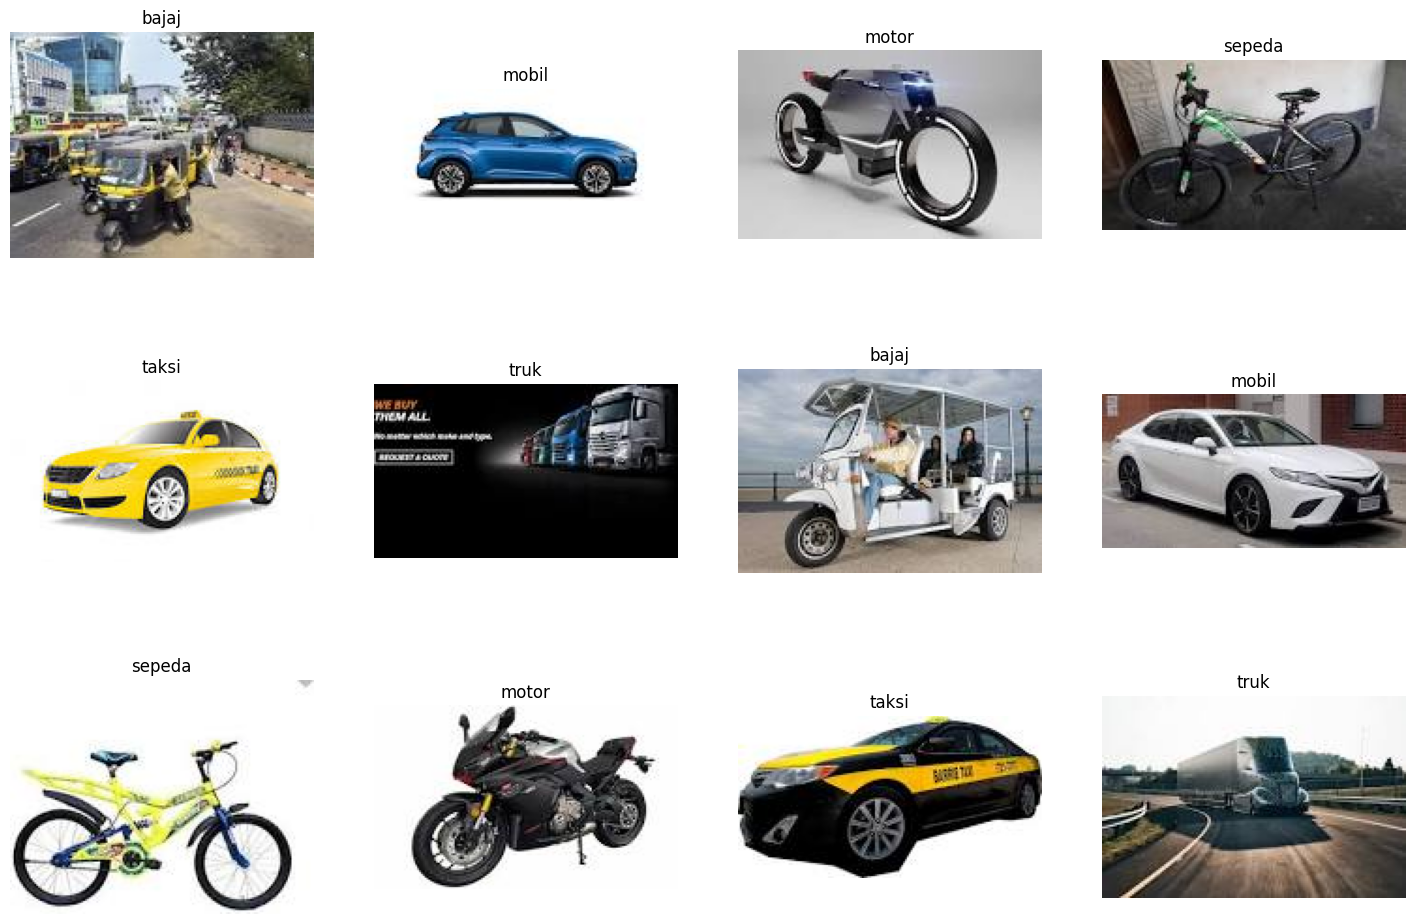

In [3]:
images = [
    TRAIN_DIR + "/bajaj/bajaj_1.jpg", TRAIN_DIR + "/mobil/mobil_1.jpg",
    TRAIN_DIR + "/motor/motor_1.jpg", TRAIN_DIR + "/sepeda/sepeda_1.jpg",
    TRAIN_DIR + "/taksi/taksi_1.jpg", TRAIN_DIR + "/truk/truk_1.jpg",
    TRAIN_DIR + "/bajaj/bajaj_18.jpg", TRAIN_DIR + "/mobil/mobil_18.jpg",
    TRAIN_DIR + "/sepeda/sepeda_18.jpg",TRAIN_DIR + "/motor/motor_18.jpg", 
    TRAIN_DIR + "/taksi/taksi_18.jpg", TRAIN_DIR + "/truk/truk_18.jpg",
]

categories = [image.split("/")[-2] for image in images]

plt.figure(figsize=(18, 12))
for i in range(12):
    img = plt.imread(images[i])
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(categories[i])
    plt.axis("off")
plt.show()

In [4]:
train_path = '/kaggle/input/private-modul-6-dataset/train'

batch_size = 64
img_height = 224
img_width = 224
seed_train_validation = 1 
shuffle_value = True
validation_split = 0.1


# untuk load training images
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=validation_split,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  seed = seed_train_validation,
  shuffle = shuffle_value )

# untuk load validation images
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed = seed_train_validation,
    shuffle = shuffle_value )

Found 1935 files belonging to 6 classes.
Using 1742 files for training.
Found 1935 files belonging to 6 classes.
Using 193 files for validation.


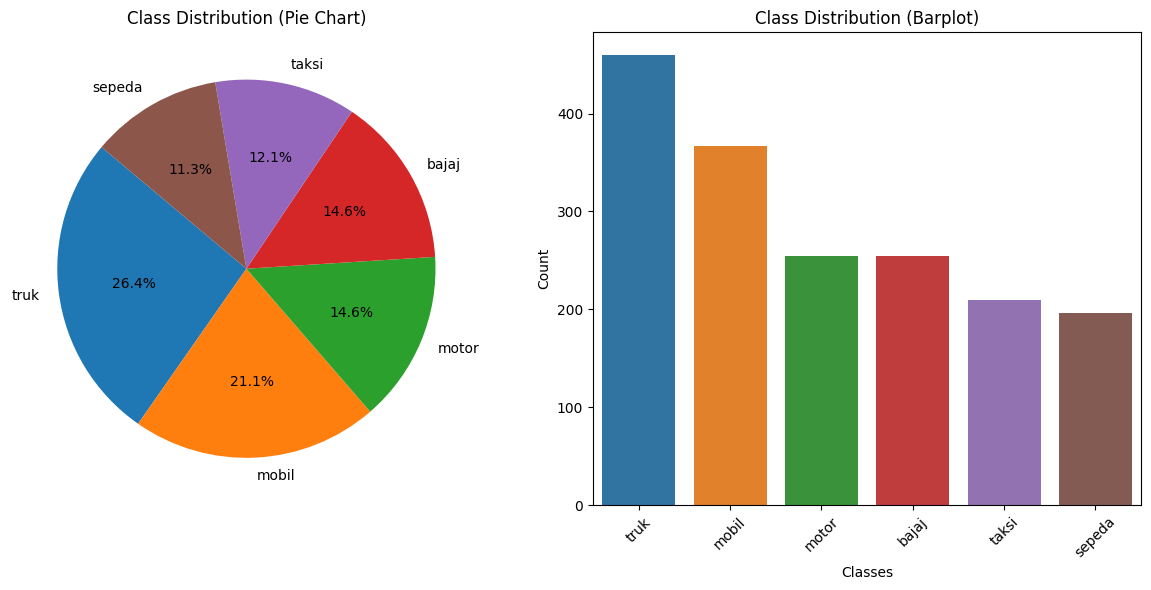

In [5]:
class_names = train_ds.class_names

class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_ds:
    labels = labels.numpy()  
    for label in labels:
        label_name = class_names[label]
        class_counts[label_name] += 1

# Now that we have the counts, let's sort them
sorted_counts_labels = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)
sorted_labels, sorted_counts = zip(*sorted_counts_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart
sorted_counts = [int(count) for count in sorted_counts]  # Convert to int in case of float
axs[0].pie(sorted_counts, labels=sorted_labels, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Class Distribution (Pie Chart)')

# Barplot
sns.barplot(x=np.array(sorted_labels), y=np.array(sorted_counts), ax=axs[1])
axs[1].set_title('Class Distribution (Barplot)')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [6]:
# target class names
class_names = train_ds.class_names
print("the target classes are: ",*class_names, sep =" ,")

the target classes are:  ,bajaj ,mobil ,motor ,sepeda ,taksi ,truk


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Modeling

In [8]:
efficientnet_v2_b3 = 'https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-ft1k-b3-classification/versions/1'
# efficientnet_v2_b0 = 'https://www.kaggle.com/models/google/efficientnet-v2/frameworks/tensorFlow2/variations/imagenet21k-ft1k-b0-classification'
# efficientnet_v2_xl = 'https://www.kaggle.com/models/google/efficientnet-v2/frameworks/tensorFlow2/variations/imagenet21k-xl-classification'
# efficientnet_v2_l = 'https://www.kaggle.com/models/google/efficientnet-v2/frameworks/tensorFlow2/variations/imagenet21k-l-classification'
# efficientnet_v2_m = 'https://www.kaggle.com/models/google/efficientnet-v2/frameworks/tensorFlow2/variations/imagenet21k-m-classification'
feature_extractor_model = efficientnet_v2_b3

# extraction layer
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_width, img_height, 3),
    trainable=False)

# classification layer
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              14467622  
                                                                 
 dense (Dense)               (None, 6)                 6006      
                                                                 
Total params: 14473628 (55.21 MB)
Trainable params: 6006 (23.46 KB)
Non-trainable params: 14467622 (55.19 MB)
_________________________________________________________________


In [9]:
# compile model
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

# early stopping kalo terlalu loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

NUM_EPOCHS = 20

In [10]:
# train model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, TqdmCallback(verbose=0)],verbose=0)

# model accuracy
model_acc = '{:.2%}'.format(history.history['acc'][-1])
print(f"\n Model Accuracy Reached: {model_acc}")

0epoch [00:00, ?epoch/s]


 Model Accuracy Reached: 99.25%


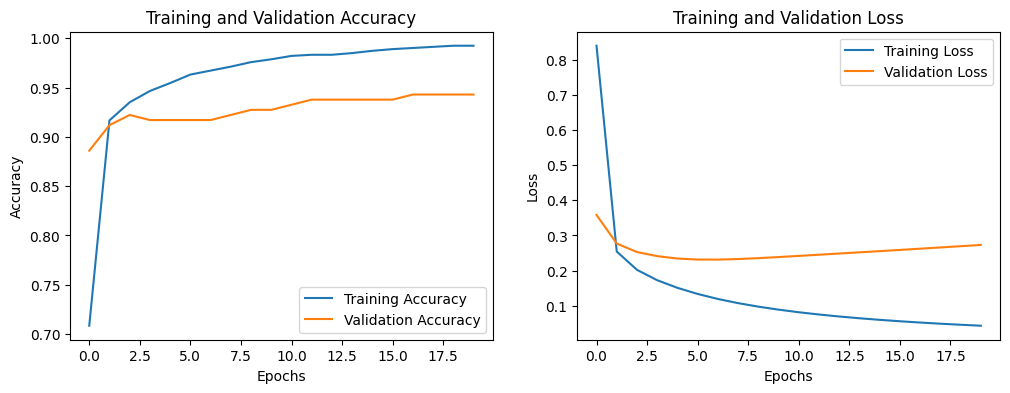

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(NUM_EPOCHS)

# Plot akurasi training dan validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [12]:
class_names = ['bajaj', 'mobil', 'motor', 'sepeda', 'taksi', 'truk']

def process_and_predict(image_path):
    # Replace with the target size you used when training your model
    img = load_img(image_path, target_size=(img_height, img_width))
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0

    # Predict using the loaded model
    pred = model.predict(img_tensor)
    pred_class = class_names[np.argmax(pred)]
    return pred_class

# Path to your test image
test_image_path = '/kaggle/input/private-modul-6-dataset/test/test_23.jpg'

# Run this in your Kaggle notebook or local environment where TensorFlow is installed
predicted_class = process_and_predict(test_image_path)
print(predicted_class)

1/1 [==============================] - 1s 1s/step
bajaj


In [13]:
# Directory containing your test images
test_images_directory = '/kaggle/input/private-modul-6-dataset/test'

# Function to process and predict the class of an image
def process_and_predict(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Replace with the size you used for training
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0
    pred = model.predict(img_tensor)
    pred_class = class_names[np.argmax(pred)]
    return pred_class

# Function to extract the number from the file name
def extract_number(file_name):
    match = re.search(r'(\d+)', file_name)
    return int(match.group()) if match else None

# List to store prediction results
results = []

# Loop over the files in the test directory and make predictions
for img_file in sorted(os.listdir(test_images_directory), key=lambda x: extract_number(x)):
    image_path = os.path.join(test_images_directory, img_file)
    predicted_class = process_and_predict(image_path)
    results.append({'file_name': img_file, 'class': predicted_class})

# Convert the list to a DataFrame
predictions_df = pd.DataFrame(results)

# Sort the DataFrame based on the extracted number from the file name
predictions_df['file_number'] = predictions_df['file_name'].apply(extract_number)
predictions_df = predictions_df.sort_values(by='file_number').drop('file_number', axis=1)

# Save the DataFrame to a CSV file
csv_output_path = '/kaggle/working/predictions.csv'
predictions_df.to_csv(csv_output_path, index=False)

print(f"Predictions saved to {csv_output_path}")

1/1 [==============================] - 0s 28ms/step
Predictions saved to /kaggle/working/predictions.csv
